In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import sys
sys.path.append('..')
import complexitylib as complex

### Data Preprocessing

In [2]:
# Convert patients_clusters.csv to a numpy 2darray

file_path = '../output/patients_clusters.csv'

# csv to numpy 2darray
clusters = np.loadtxt(file_path, delimiter=',', skiprows=1, dtype=str)

In [3]:
patients = []
for i, pat in enumerate(clusters):
    patients.append(complex.Patient(name=pat[0], cluster=int(pat[1]), id=i))


In [4]:
# drop patients DD09, DD45 and DD53 because they miss a second recording
# drop patients DD28 because their second recording is corrupted
patients = [p for p in patients if p.name not in ['DD09', 'DD28', 'DD45', 'DD53']]

In [5]:
rec, labels = patients[0].get_eeg_before()
print(rec.shape)
ch1 = rec[0].tolist()

(32, 95744)


In [6]:
aggregate_data = []
group_labels = []
conditions = []


unique_clusters = set(p.cluster for p in patients)
for i in range(len(unique_clusters)):
    # get patients in cluster i
    patients_in_cluster = [p for p in patients if p.cluster == i]
    group_data = []
    for pat in patients_in_cluster:
        # pre-treatment
        signal, channels = pat.get_eeg_before()
        # signal as nested list
        group_data.append(signal.tolist())
        group_labels.append(pat.cluster)
        conditions.append('pre')
    aggregate_data.append(group_data)
    group_data = []
    for pat in patients_in_cluster:
        # post-treatment
        signal, channels = pat.get_eeg_after()
        group_data.append(signal.tolist())
        group_labels.append(pat.cluster)
        conditions.append('post')
    aggregate_data.append(group_data)

In [10]:
# find the shortest signal in aggregate_data
min_length = min([len(signal) for group in aggregate_data for channel in group for signal in channel])
print(min_length)

89600


In [11]:
for group in aggregate_data:
    for channel in group:
        for i, signal in enumerate(channel):
            # truncate signal to min_length
            channel[i] = signal[:min_length]

In [ ]:
# Concatenate all group data
eeg_data_all = np.concatenate(aggregate_data, axis=0)

# downsample eeg_data_all to 10000 samples for the computational intensive functions
eeg_data_downsample = np.zeros((eeg_data_all.shape[0], eeg_data_all.shape[1], 10000))
for i in range(eeg_data_all.shape[0]):
    for j in range(eeg_data_all.shape[1]):
        eeg_data_downsample[i, j] = eeg_data_all[i, j, :10000]
eeg_data_downsample.shape

### Spectral Entropy

In [7]:
#Spectral Entropy
from antropy import spectral_entropy
from collections import defaultdict

def compute_subject_spen(eeg_subject, sf=500, method='welch', normalize=True):
    """
    eeg_subject: shape (n_channels, n_timepoints)
    Returns: average spectral entropy across channels
    """
    return np.mean([
        spectral_entropy(eeg_subject[ch], sf=sf, method=method, normalize=normalize)
        for ch in range(eeg_subject.shape[0])
    ])


def compare_6_groups_spen(eeg_data, group_labels, conditions, sf=500):
    """
    eeg_data: shape (n_subjects, n_channels, n_timepoints)
    group_labels: list of group IDs (0, 1, 2)
    conditions: list of 'pre' or 'post'
    """
    assert len(group_labels) == len(conditions) == eeg_data.shape[0], "Input mismatch"

    group_data = defaultdict(list)

    for i in range(len(eeg_data)):
        print(f'subject {i} being processed...')
        spen = compute_subject_spen(eeg_data[i], sf=sf)
        key = (group_labels[i], conditions[i])
        group_data[key].append(spen)

    # Plotting
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[k] for k in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]

    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Spectral Entropy")
    plt.title("Spectral Entropy: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return group_data

subject 0 being processed...
subject 1 being processed...
subject 2 being processed...
subject 3 being processed...
subject 4 being processed...
subject 5 being processed...
subject 6 being processed...
subject 7 being processed...
subject 8 being processed...
subject 9 being processed...
subject 10 being processed...
subject 11 being processed...
subject 12 being processed...
subject 13 being processed...
subject 14 being processed...
subject 15 being processed...
subject 16 being processed...
subject 17 being processed...
subject 18 being processed...
subject 19 being processed...
subject 20 being processed...
subject 21 being processed...
subject 22 being processed...
subject 23 being processed...
subject 24 being processed...
subject 25 being processed...
subject 26 being processed...
subject 27 being processed...
subject 28 being processed...
subject 29 being processed...
subject 30 being processed...
subject 31 being processed...
subject 32 being processed...
subject 33 being pro

C:\Users\aless\AppData\Local\Temp\ipykernel_30440\488920881.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=group_names)


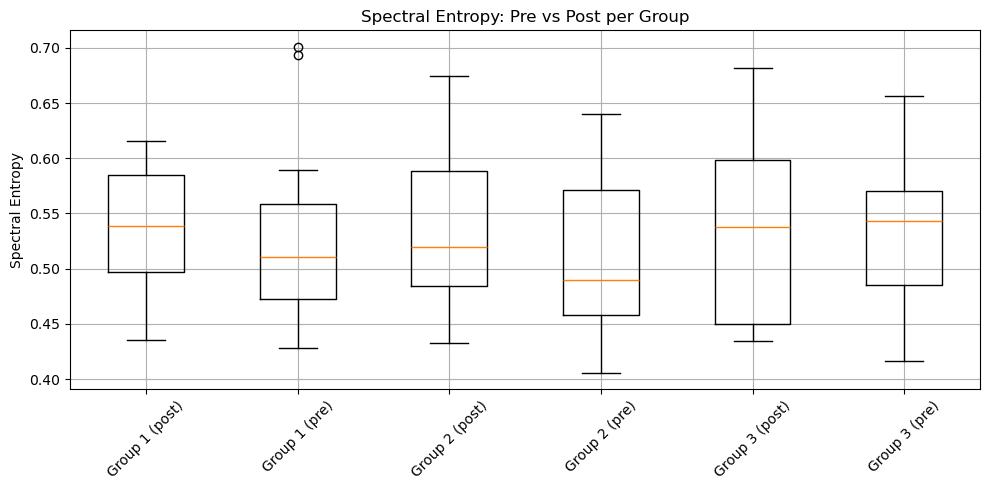

In [ ]:
sf = 500  # sampling frequency in Hz

# Run comparison
spen_results = compare_6_groups_spen(eeg_data_all, group_labels, conditions, sf=sf)

### Permutation Entropy

In [14]:
#permutation entropy
from antropy import perm_entropy

def compute_subject_permen(eeg_subject, order=3, delay=1, normalize=True):
    """
    eeg_subject: shape (n_channels, n_timepoints)
    Returns: mean permutation entropy across all channels
    """
    return np.mean([
        perm_entropy(eeg_subject[ch], order=order, delay=delay, normalize=normalize)
        for ch in range(eeg_subject.shape[0])
    ])

def compare_6_groups_permen(eeg_data, group_labels, conditions, order=3, delay=1):
    """
    eeg_data: shape (n_subjects, n_channels, n_timepoints)
    group_labels: list of group IDs (0, 1, 2)
    conditions: list of 'pre' or 'post'
    """
    assert len(group_labels) == len(conditions) == eeg_data.shape[0], "Input mismatch"

    group_data = defaultdict(list)

    for i in range(len(eeg_data)):
        print(f'subject {i} being processed...')
        pe = compute_subject_permen(eeg_data[i], order=order, delay=delay)
        key = (group_labels[i], conditions[i])
        group_data[key].append(pe)

    # Plot
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[k] for k in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]

    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Permutation Entropy")
    plt.title("Permutation Entropy: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return group_data

subject 0 being processed...
subject 1 being processed...
subject 2 being processed...
subject 3 being processed...
subject 4 being processed...
subject 5 being processed...
subject 6 being processed...
subject 7 being processed...
subject 8 being processed...
subject 9 being processed...
subject 10 being processed...
subject 11 being processed...
subject 12 being processed...
subject 13 being processed...
subject 14 being processed...
subject 15 being processed...
subject 16 being processed...
subject 17 being processed...
subject 18 being processed...
subject 19 being processed...
subject 20 being processed...
subject 21 being processed...
subject 22 being processed...
subject 23 being processed...
subject 24 being processed...
subject 25 being processed...
subject 26 being processed...
subject 27 being processed...
subject 28 being processed...
subject 29 being processed...
subject 30 being processed...
subject 31 being processed...
subject 32 being processed...
subject 33 being pro

C:\Users\aless\AppData\Local\Temp\ipykernel_30440\3414291800.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=group_names)


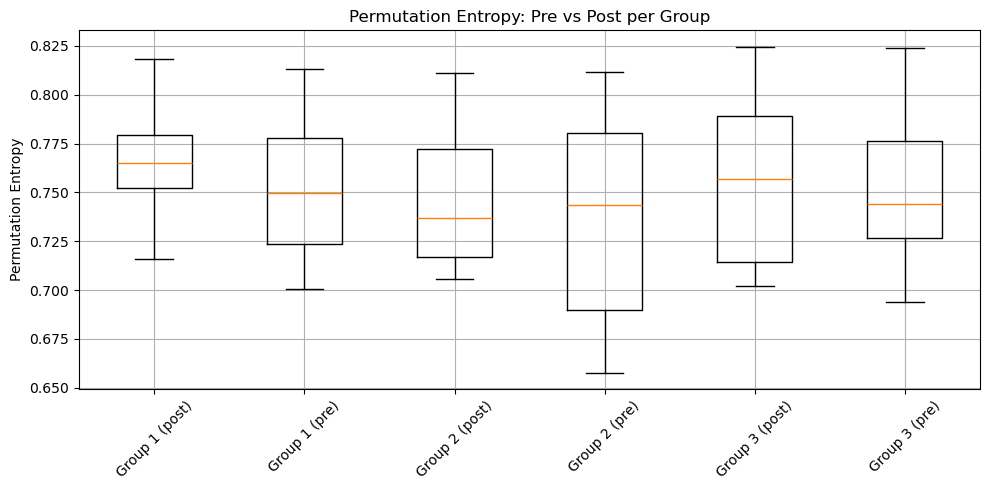

In [15]:
# Run permutation entropy comparison
permen_results = compare_6_groups_permen(eeg_data_all, group_labels, conditions)

### Lempel-Ziv Complexity

In [16]:
#lzc
import numpy as np
import matplotlib.pyplot as plt
from antropy import lziv_complexity
from collections import defaultdict

def compute_subject_lzc(eeg_subject, normalize=True):
    """
    Compute mean Lempel-Ziv Complexity across channels.
    Signal is binarized per channel using mean threshold.
    """
    return np.mean([
        lziv_complexity((eeg_subject[ch] > np.mean(eeg_subject[ch])).astype(int), normalize=normalize)
        for ch in range(eeg_subject.shape[0])
    ])


def compare_6_groups_lzc(eeg_data, group_labels, conditions, normalize=True):
    """
    eeg_data: shape (n_subjects, n_channels, n_timepoints)
    group_labels: list of group IDs (0, 1, 2)
    conditions: list of 'pre' or 'post'
    """
    assert len(group_labels) == len(conditions) == eeg_data.shape[0], "Input mismatch"

    group_data = defaultdict(list)

    for i in range(len(eeg_data)):
        print(f'subject {i} being processed...')
        lzc = compute_subject_lzc(eeg_data[i], normalize=normalize)
        key = (group_labels[i], conditions[i])
        group_data[key].append(lzc)

    # Plot
    all_groups = sorted(group_data.keys())
    plot_data = [group_data[k] for k in all_groups]
    group_names = [f"Group {g+1} ({c})" for g, c in all_groups]

    plt.figure(figsize=(10, 5))
    plt.boxplot(plot_data, labels=group_names)
    plt.ylabel("Lempel-Ziv Complexity")
    plt.title("LZC: Pre vs Post per Group")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return group_data

subject 0 being processed...
subject 1 being processed...
subject 2 being processed...
subject 3 being processed...
subject 4 being processed...
subject 5 being processed...
subject 6 being processed...
subject 7 being processed...
subject 8 being processed...
subject 9 being processed...
subject 10 being processed...
subject 11 being processed...
subject 12 being processed...
subject 13 being processed...
subject 14 being processed...
subject 15 being processed...
subject 16 being processed...
subject 17 being processed...
subject 18 being processed...
subject 19 being processed...
subject 20 being processed...
subject 21 being processed...
subject 22 being processed...
subject 23 being processed...
subject 24 being processed...
subject 25 being processed...
subject 26 being processed...
subject 27 being processed...
subject 28 being processed...
subject 29 being processed...
subject 30 being processed...
subject 31 being processed...
subject 32 being processed...
subject 33 being pro

C:\Users\aless\AppData\Local\Temp\ipykernel_30440\1074648590.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=group_names)


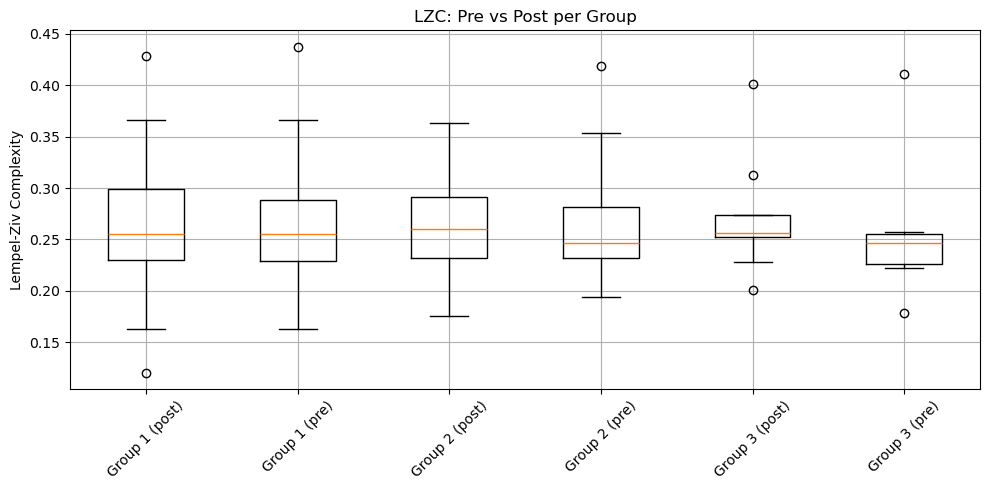

In [17]:
# Run LZC comparison
lzc_results = compare_6_groups_lzc(eeg_data_all, group_labels, conditions)

### Multi Scale Entropy

In [33]:
#fast MSE
from antropy import sample_entropy

def multiscale_entropy(signal, max_scale=5, m=2):
    """
    Compute Multiscale Entropy (MSE) using sample entropy from antropy.
    Parameters:
        signal: 1D numpy array
        max_scale: number of coarse-graining scales
        m: embedding dimension for sample entropy
    Returns:
        mse: np.array of sample entropy values at each scale
    """
    mse = []
    for scale in range(1, max_scale + 1):
        if len(signal) < scale:
            mse.append(np.nan)
            continue
        # Coarse-graining
        n = len(signal) // scale
        coarse = np.mean(signal[:n * scale].reshape(n, scale), axis=1)
        se = sample_entropy(coarse, order=m)
        mse.append(se)
    return np.array(mse)


def compute_subject_mse(eeg_subject, max_scale=5, m=2):
    """
    eeg_subject: shape (n_channels, n_timepoints)
    Returns: MSE curve (mean across channels)
    """
    channel_mse = np.array([
        multiscale_entropy(eeg_subject[ch], max_scale=max_scale, m=m)
        for ch in range(eeg_subject.shape[0])
    ])
    return np.nanmean(channel_mse, axis=0)


import matplotlib.pyplot as plt
from collections import defaultdict

def compare_mse_6_groups(eeg_data, group_labels, conditions, max_scale=5, m=2):
    """
    Compute and compare group-wise average MSE curves.
    """
    group_data = defaultdict(list)

    for i in range(len(eeg_data)):
        print(f'subject {i} being processed...')
        mse = compute_subject_mse(eeg_data[i], max_scale=max_scale, m=m)
        key = (group_labels[i], conditions[i])
        group_data[key].append(mse)

    # Plot MSE curves
    all_keys = sorted(group_data.keys())
    plt.figure(figsize=(10, 5))
    for key in all_keys:
        label = f"Group {key[0]+1} ({key[1]})"
        data = np.array(group_data[key])
        mean_curve = np.nanmean(data, axis=0)
        plt.plot(range(1, max_scale+1), mean_curve, marker='o', label=label)

    plt.xlabel("Scale")
    plt.ylabel("Mean Sample Entropy")
    plt.title("Multiscale Entropy (MSE) Across Groups")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return group_data

subject 0 being processed...
subject 1 being processed...
subject 2 being processed...
subject 3 being processed...
subject 4 being processed...
subject 5 being processed...
subject 6 being processed...
subject 7 being processed...
subject 8 being processed...
subject 9 being processed...
subject 10 being processed...
subject 11 being processed...
subject 12 being processed...
subject 13 being processed...
subject 14 being processed...
subject 15 being processed...
subject 16 being processed...
subject 17 being processed...
subject 18 being processed...
subject 19 being processed...
subject 20 being processed...
subject 21 being processed...
subject 22 being processed...
subject 23 being processed...
subject 24 being processed...
subject 25 being processed...
subject 26 being processed...
subject 27 being processed...
subject 28 being processed...
subject 29 being processed...
subject 30 being processed...
subject 31 being processed...
subject 32 being processed...
subject 33 being pro

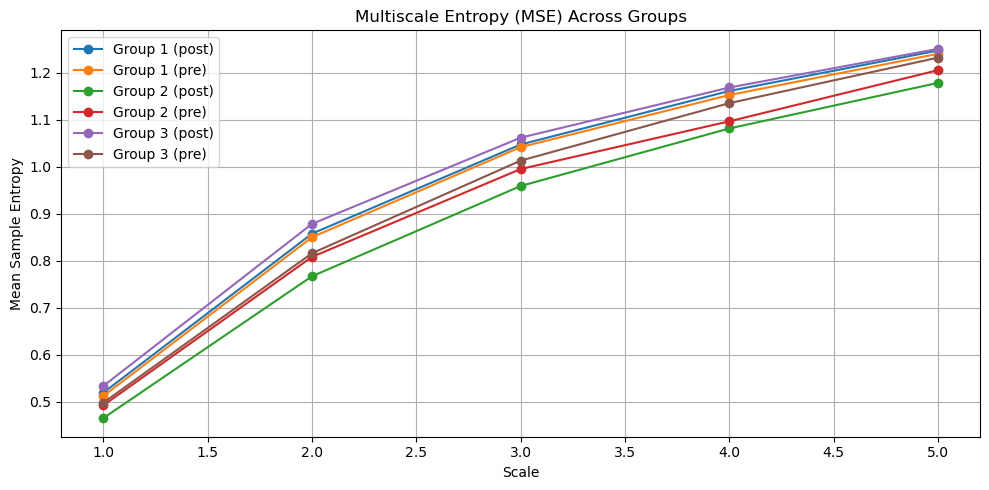

In [35]:
# Run group comparison
mse_results = compare_mse_6_groups(eeg_data_downsample, group_labels, conditions, max_scale=5, m=2)